# Survival Analysis in Python

The Weibull distribution

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
from empyrical_dist import Pmf, Cdf, Surv, Hazard

### Generate a Weibull sample

In [2]:
from scipy.stats import weibull_min

In [3]:
def make_weibull(lam, k, loc=0):
    return weibull_min(c=k, loc=loc, scale=lam)

In [39]:
lam = 0.75
k = 1.25
loc = 2

rv = make_weibull(lam=lam, k=k, loc=loc)

sample = rv.rvs(size=1000, random_state=17)

### Survival function

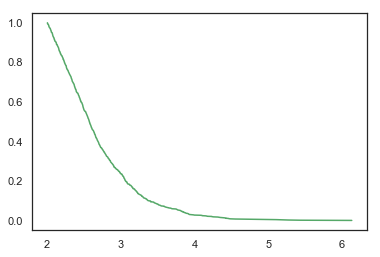

In [40]:
surv = Surv.from_seq(sample)
surv.plot()

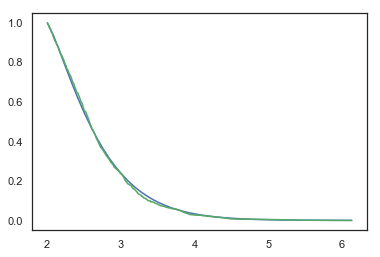

In [41]:
xs = np.linspace(min(sample), max(sample))
ys = rv.sf(xs)
plt.plot(xs, ys)
surv.plot()

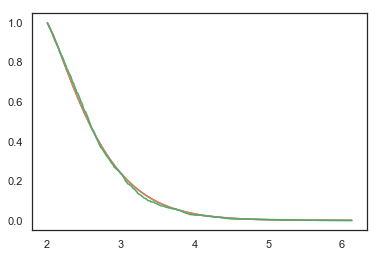

In [42]:
xs = np.linspace(min(sample), max(sample))

# using the Wikipedia parameterization
ys = np.exp(-((xs-loc)/lam)**k)
plt.plot(xs, ys)

# using Scipy
ys2 = rv.sf(xs)
plt.plot(xs, ys2)

# plotting the empirical CDF
surv.plot()

In [43]:
max(abs(ys-ys2))

0.0

In [44]:
lam, k, loc

(0.75, 1.25, 2)

### Increasing and decreasing hazards

In [45]:
def plot_hf(lam, k, loc, **kwargs):
    xs = np.linspace(0.01, 5)
    ys = k / lam * ((xs-loc)/lam)**(k-1)
    plt.plot(xs, ys, **kwargs)

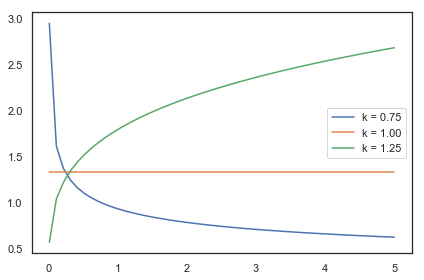

In [46]:
def sweep_k():
    lam = 0.75
    loc = 0

    ks = [0.75, 1, 1.25]
    for k in ks:
        plot_hf(lam, k, loc, label='k = %0.2lf' % k)
    
    decorate()
    
sweep_k()

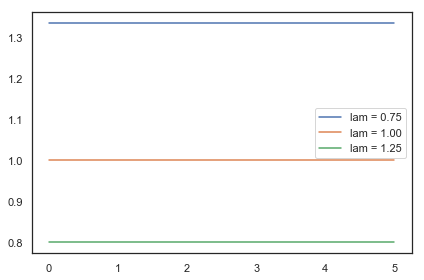

In [47]:
def sweep_lam(k):
    loc = 0

    lams = [0.75, 1, 1.25]
    for lam in lams:
        plot_hf(lam, k, loc, label='lam = %0.2lf' % lam)
    
    decorate()
    
sweep_lam(k=1.0)

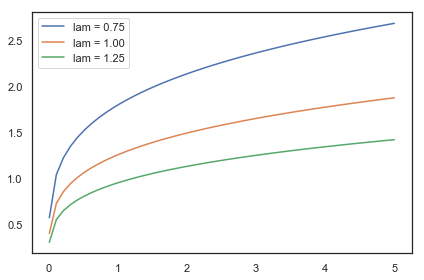

In [48]:
sweep_lam(k=1.25)

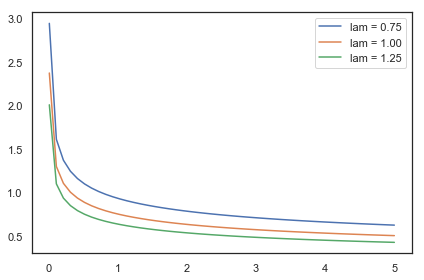

In [49]:
sweep_lam(k=0.75)

### Cumulative hazard function

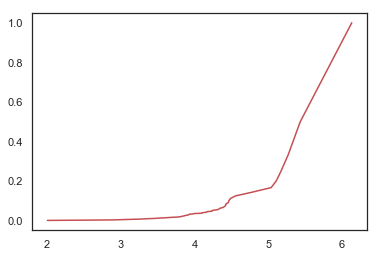

In [50]:
haz = Hazard.from_seq(sample)
haz.plot()

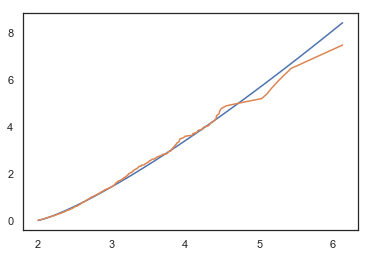

In [51]:
def compare_hazard(sample, lam, k, loc):
    
    # using the Wikipedia parameterization
    xs = np.linspace(min(sample), max(sample))
    ys = ((xs-loc)/lam)**k
    plt.plot(xs, ys)

    haz = Hazard.from_seq(sample)
    haz.cumsum().plot()
    
compare_hazard(sample, lam, k, loc)

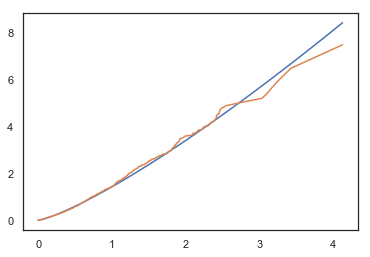

In [52]:
loc_est = min(sample) 
shifted = sample - loc_est

compare_hazard(shifted, lam, k, 0)

### Cumulative hazard

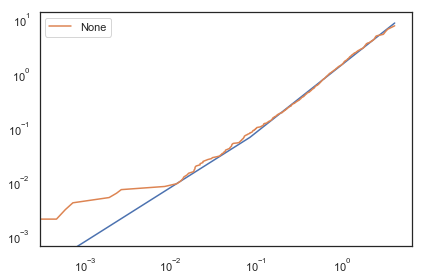

In [53]:
compare_hazard(shifted, lam, k, 0)
decorate(xscale='log', yscale='log')

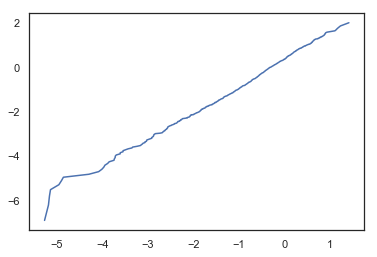

In [60]:
from scipy.stats import linregress

def plot_cum_haz_log(haz, loc):
    xs = np.log(haz.qs - loc)
    ys = np.log(haz.ps.cumsum())
    plt.plot(xs, ys)
    
    res = linregress(xs, ys)
    return xs, res
    
haz = Hazard.from_seq(sample)
xs, res = plot_cum_haz_log(haz, loc=2)

In [61]:
k_est = res.slope
k_est, k

(1.2323005034911274, 1.25)

In [62]:
lam_est = np.exp(-res.intercept / k_est)
lam_est, lam

(0.7529848863508851, 0.75)

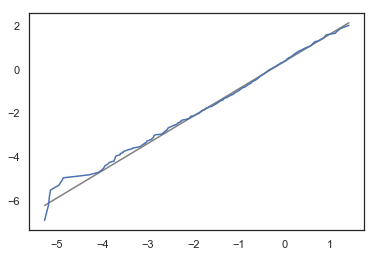

In [64]:
slope = k
inter = -k * np.log(lam)

ys = xs * slope + inter
plt.plot(xs, ys, color='gray')

xs, res = plot_cum_haz_log(haz, loc=loc)

### Estimation

In [76]:
lam = 0.75
k = 1.25
loc = 2

rv = make_weibull(lam=lam, k=k, loc=loc)

sample = rv.rvs(size=1000, random_state=17)

In [77]:
def logpdf(theta, sample):
    lam, k, loc = theta
    xs = (sample - loc) / lam
    
    a = np.log(k/lam) + (k-1) * np.log(xs) - (xs)**k
    return -sum(a)

Let's get Wolfram to compute the partial derivatives

`derivative of log(k/λ ((x-m)/λ)^(k-1) exp(-(x-m)/λ)) with respect to λ`


In [78]:
def jacobian(theta, sample):
    lam, k, loc = theta
    xs = sample - loc
    
    a = 1/k + np.log(xs/lam)
    b = -k/lam + xs/lam/lam
    c = 1/lam - (k-1) / xs
    return sum(a), sum(b), sum(c)

In [79]:
theta = (lam_est, k_est, 0)
theta

(0.7529848863508851, 1.2323005034911274, 0)

In [80]:
logpdf(theta, sample)

4053.5318647545446

In [87]:
theta0 = 0.7, 1.2, 1
theta0

(0.7, 1.2, 1)

In [88]:
logpdf(theta0, sample)

2214.913551097487

In [89]:
jacobian(theta0, sample)

(1671.9374859836666, 1743.0123092545368, 1299.9766732676262)

In [94]:
from scipy.optimize import minimize

theta = (lam_est, k_est, 0)
args = (sample,)
minimize(logpdf, theta, args=args, jac=jacobian, method='Nelder-Mead')

/home/downey/anaconda3/envs/SurvivalAnalysisPython/lib/python3.5/site-packages/scipy/optimize/_minimize.py:502: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/home/downey/anaconda3/envs/SurvivalAnalysisPython/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/home/downey/anaconda3/envs/SurvivalAnalysisPython/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


 final_simplex: (array([[0.74192297, 1.25554905, 2.002828  ],
       [0.74200848, 1.2556184 , 2.00282471],
       [0.74200543, 1.25550833, 2.00282987],
       [0.74200396, 1.25563392, 2.0028315 ]]), array([592.93637512, 592.93637837, 592.93637992, 592.93638111]))
           fun: 592.9363751249787
       message: 'Optimization terminated successfully.'
          nfev: 364
           nit: 206
        status: 0
       success: True
             x: array([0.74192297, 1.25554905, 2.002828  ])

In [91]:
def fit_weibull(sample):
    k_est, loc_est, lam_est = weibull_min.fit(sample)
    return lam_est, k_est, loc_est

In [92]:
est = fit_weibull(sample)
est

(0.7419608735596266, 1.2555400072952216, 2.002825469006808)

In [100]:
df = pd.DataFrame()
df['duration'] = sample
df['event'] = 1
df.head()

,duration,event
0,2.323150,1
1,2.599796,1
2,2.217326,1
3,2.089681,1
4,3.062962,1


In [101]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df, duration_col='duration', event_col='event', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.00000, step_size = 0.9500, ll = -5912.12818, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 1 iterations.
<lifelines.CoxPHFitter: fitted with 1000 observations, 0 censored>
      duration col = 'duration'
         event col = 'event'
number of subjects = 1000
  number of events = 1000
    log-likelihood = -5912.13
  time fit was run = 2019-05-13 23:36:48 UTC

---
Empty DataFrame
Columns: [coef, exp(coef), se(coef), z, p, -log2(p), lower 0.95, upper 0.95]
Index: []
---
Concordance = 0.50
Log-likelihood ratio test = 0.00 on 0 df, -log2(p)=nan


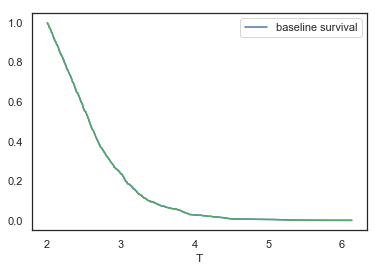

In [104]:
cph.baseline_survival_.plot()
surv.plot()

In [112]:
baseline = cph.baseline_survival_['baseline survival']

In [113]:
max(abs(surv - baseline))

0.0005611788707607432

In [95]:
from lifelines import CoxPHFitter


cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.50881, step_size = 0.9500, ll = -675.38063, newton_decrement = 16.76434, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.13852, step_size = 0.9500, ll = -659.79004, newton_decrement = 0.99157, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01802, step_size = 0.9500, ll = -658.76197, newton_decrement = 0.01422, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00108, step_size = 1.0000, ll = -658.74771, newton_decrement = 0.00005, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2019-05-12 20:04:29 UTC

---
      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper

In [96]:
cph.hazards_

fin    -0.379422
age    -0.057438
race    0.313900
wexp   -0.149796
mar    -0.433704
paro   -0.084871
prio    0.091497
dtype: float64

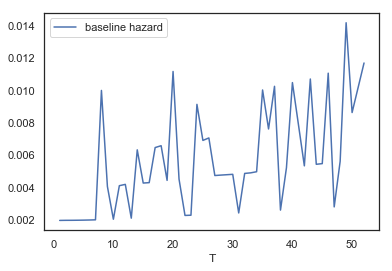

In [98]:
cph.baseline_hazard_.plot()